# S09 - Modèle de diffusion de Bass - démo complète

Dans la séance 2, nous avons défini les deux fonctions suivantes pour le modèle de diffusion de Bass :

Le nombre cumulé d'adoptants (personnes qui ont acheté/adopté le produit) $S(t)$ depuis le début (temps 0) jusqu'au temps $t$ est décrit par $S(t) = m\times F(t)$ où $m$ est la taille du marché (le nombre total estimé de clients potentiels) et $F(t)$ est la probabilité <i>cumulative</i> qu'un individu (client potentiel) ait déjà adopté le produit au temps $t$ (qui doit être calculée).
Nous pouvons obtenir $F(t)$ en fonction de $p$ et $q$ comme suit :

$$F(t) = \frac{1-e^{-(p+q)t}}{1+\frac{q}{p}e^{-(p+q)t}} $$

où
* $p$ est le coefficient d'innovation
* $q$ est le coefficient d'imitation

De plus, la probabilité d'adoption par un individu à l'instant $t$ qui est représentée par $f(t)$ (rappelons que $f(t) = \frac{d}{dt}F(t)$) peut être calculée comme suit :

$$f(t) = \frac{d}{dt}F(t) = \frac{e^{(p+q)t}p(p+q)^2}{[p e^{(p+q)t} + q]^2} \text{.}$$

Par conséquent, le nombre estimé d'adoptions dans chaque période peut être calculé comme $s(t) = m\times f(t)$

Nous avons ensuite préparé les deux fonctions suivantes pour calculer $F(t)$ et $f(t)$.

In [9]:
import math

def Bass_cumulative_probability_Ft(p, q, t):
    return (1 - math.exp(-(p + q) * t)) / (1 + (q / p) * math.exp(-(p + q) * t))

def Bass_probability_ft(p, q, t):
    return (math.exp((p + q) * t) * p * (p + q)**2) / (p * math.exp((p + q) * t) + q)**2

Sur la base des valeurs de $p$, $q$ et $m$ des ventes trimestrielles d'iPhone fournies dans la cellule de code ci-dessous, veuillez calculer les valeurs de la probabilité estimée d'adoption $f(t)$, de la probabilité cumulée d'adoption $F(t)$, du nombre d'adoptions $s(t) = m\times f(t)$ et du nombre cumulé d'adoptions $S(t) = m\times F(t)$ pour chaque trimestre, qui est indexé par $t$. Notez que la première colonne ci-dessous est un index tandis que les quatre colonnes suivantes contiennent les valeurs correspondantes des estimations basées sur le modèle de diffusion de Bass.

|Quarter| ft | Ft| st | St | 
| :- | :- | :- | :- | :- | 
|...| ... |...| ... |...|

### Régression pour l'estimation des paramètres de Bass (il s'agit de la partie supplémentaire du notebook dans S04)
**Estimation des paramètres du modèle de diffusion des basses**

Nous pouvons maintenant compléter le pipeline du modèle de diffusion de Bass en estimant d'abord les paramètres $p$, $q$ et $m$ à partir des données avant d'effectuer la prédiction. Nous chargeons d'abord les modules nécessaires ainsi que les données réelles des ventes d'iPhone. Le modèle de régression pour l'estimation des paramètres est présenté dans l'article ci-dessous (Section « Discrete Analogue »).

<b>Référence</b> : Bass, F. M. (1969). A new product growth for model consumer durables. Management science, 15(5), 215-227.


In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

url = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/data/iphone_quarter_sales.csv'
actual_sales = pd.read_csv(url, index_col='Quarter')
actual_sales.head()

,Sales
Quarter,
0,0.270
1,1.119
2,2.315
3,1.703
4,0.717


Nous allons d'abord déterminer les coefficients du modèle de diffusion de Bass afin de réaliser la prédiction telle que vue dans la session précédente. Le modèle de Bass, sous une forme basique, peut s'écrire comme suit :

$s(t) = pm + (q-p)S(t) - \frac{q}{m}S(t)^2$

qui peut être résolu par une fonction de régression. Ici nous utiliserons l'équation suivante (notez que nous ne décalons pas d'une période comme dans l'article car la période est un peu longue).

$s(t) = a + bS(t) + cS(t)^2$

En conséquence, nous pouvons obtenir $m = \frac{-b \pm \sqrt{b^2-4ac}}{2c}$ ($m$ doit être positif), $p = a/m$ et $q = -mc$ (pour la preuve détaillée, vous pouvez consulter la section dans l'article).

Dans les étapes ci-dessous, nous démontrons comment cela peut être réalisé en utilisant le modèle de régression linéaire.

In [11]:
input = pd.DataFrame()
# nous devons préparer les entrées des ventes en prenant la somme cumulée jusqu'à la période T-1

input["sales"] = actual_sales["Sales"]
input["cumulative_sales"] = np.cumsum(actual_sales["Sales"])
input["cumulative_sales_sq"] = input["cumulative_sales"] ** 2
input.head()

,sales,cumulative_sales,cumulative_sales_sq
Quarter,,,
0,0.270,0.270,0.072900
1,1.119,1.389,1.929321
2,2.315,3.704,13.719616
3,1.703,5.407,29.235649
4,0.717,6.124,37.503376


Nous pouvons maintenant utiliser la régression linéaire pour déterminer $a$, $b$ et $c$ de la fonction de régression ci-dessus.

In [12]:
X = input[["cumulative_sales","cumulative_sales_sq"]]
y = input["sales"]
reg = LinearRegression().fit(X,y)
print("intercept: " + str(reg.intercept_))
print("coefficients: " + str(reg.coef_))

a = reg.intercept_
b = reg.coef_[0]
c = reg.coef_[1]

intercept: 3.6726987894801724
coefficients: [ 1.15612351e-01 -6.23837858e-05]


Suite aux résultats, nous pouvons obtenir

$m = \frac{-b \pm \sqrt{b^2-4ac}}{2c}$

et $m$ (la taille de la clientèle potentielle) doit être positif.

In [13]:
# déterminer m
m1 = (-b + math.sqrt(b**2-4*a*c)) / (2*c)
m2 = (-b - math.sqrt(b**2-4*a*c)) / (2*c)
m = max(m1,m2)
print("m1 = ", m1, ", m2 = ", m2, "m = ", m)

m1 =  -31.24072191263632 , m2 =  1884.4843034859591 m =  1884.4843034859591


Ensuite, nous pouvons obtenir directement $p = a/m$ et $q = -mc$ pour le modèle de diffusion de Bass.

In [14]:
p = a/m
q = -m*c
print("m = ", m, ", p = ", p, "q = ", q)

m =  1884.4843034859591 , p =  0.0019489145028623142 q =  0.11756126506137607


### Les codes suivants proviennent de la séance 4 (prédiction de la diffusion de Bass à partir des paramètres donnés)

### Question 1
Calculez les valeurs comme indiqué dans le tableau ci-dessus pour les 40 premiers trimestres de ventes (soit 10 ans) en utilisant les paramètres fournis. L'indice du trimestre doit être compris entre 0 et 39 (c'est-à-dire que le premier trimestre est considéré comme la période $t=0$).

In [15]:
import pandas as pd

column_names = ['ft', 'Ft', 'st', 'St']
quarter_index = list(range(40))
bass_df = pd.DataFrame(index=quarter_index, columns=column_names)
bass_df.index.name = 'Quarter'

### commencez votre code ici ###
bass_df['ft'] = [Bass_probability_ft(p, q, t) for t in bass_df.index]
bass_df['Ft'] = [Bass_cumulative_probability_Ft(p, q, t) for t in bass_df.index]
bass_df['st'] = [m * bass_df.at[t, 'ft'] for t in bass_df.index]
bass_df['St'] = [m * bass_df.at[t, 'Ft'] for t in bass_df.index]
### terminez votre code ici ###

bass_df.head()

,ft,Ft,st,St
Quarter,,,,
0,0.001949,0.000000,3.672699,0.000000
1,0.002187,0.002066,4.121845,3.893112
2,0.002453,0.004384,4.623538,8.261201
3,0.002751,0.006983,5.183301,13.159540
4,0.003082,0.009896,5.807073,18.649135


### Question 2
Faire les tâches suivantes:
- (i) tracer les colonnes `['ft','Ft']` dans un graphique linéaire (paramètre `kind='line'`) et
- (ii) tracer les colonnes `['st','St']` dans un graphique à barres (paramètre `kind='bar'`).

Vous pouvez également indiquer la taille des figures en utilisant le paramètre `figsize=(12,4)`.

<Axes: xlabel='Quarter'>

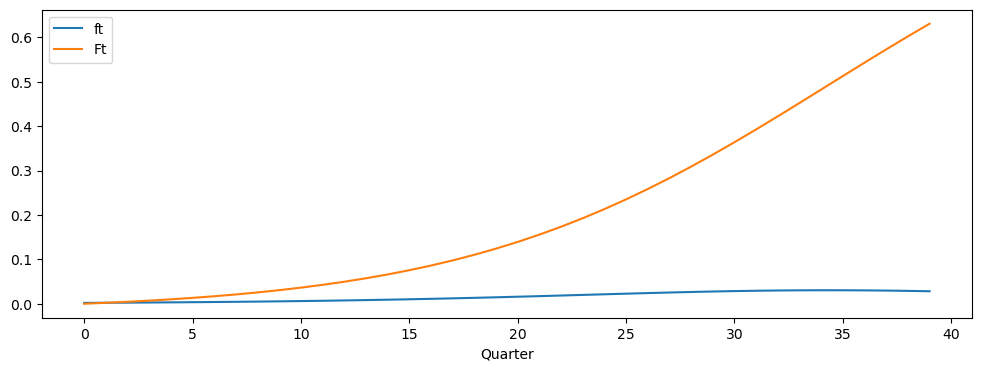

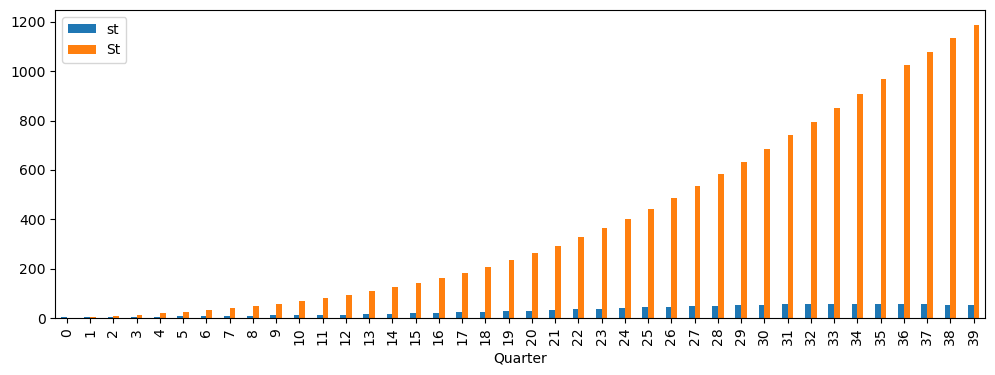

In [16]:
### commencez votre code ici ###
bass_df[['ft','Ft']].plot(figsize=(12,4))
bass_df[['st','St']].plot(kind='bar', figsize=(12,4))
### terminez votre code ici ###

### Question 3
Nous pouvons maintenant comparer les résultats avec les ventes trimestrielles réelles d'iPhone pour les 40 premiers trimestres (à partir du deuxième trimestre 2007, lorsque le produit a été lancé pour la première fois). Les données sont disponibles dans l'URL ci-dessous (au format csv) que nous pouvons télécharger dans un `DataFrame`.

In [17]:
url = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/data/iphone_quarter_sales.csv'
actual_sales = pd.read_csv(url, index_col='Quarter')
actual_sales.head()

,Sales
Quarter,
0,0.270
1,1.119
2,2.315
3,1.703
4,0.717


Ajoutez les colonnes suivantes et leurs valeurs correspondantes au DataFrame `bass_df`:

* Colonne `'Actual'` : qui contient les ventes réelles du DataFrame `actual_sales`
* Colonne `'CumulativeActual'` : qui calcule la somme du premier trimestre jusqu'à chaque trimestre de l'index
* Colonne `'PError'` : qui calcule le pourcentage d'erreur de chaque trimestre correspondant à partir de la colonne `'Actual'` et de la colonne `st` (ventes estimées pour chaque trimestre), c'est-à-dire `PError = (Actual - st) / Actual`

In [18]:
### commencez votre code ici ###
bass_df['Actual'] = actual_sales['Sales']
bass_df['CumulativeActual'] = [sum(actual_sales.loc[:t,'Sales']) for t in actual_sales['Sales'].index]
bass_df['PError'] = (bass_df['Actual'] - bass_df['st']) / bass_df['Actual']
### terminez votre code ici ###
bass_df

,ft,Ft,st,St,Actual,CumulativeActual,PError
Quarter,,,,,,,
0,0.001949,0.000000,3.672699,0.000000,0.270,0.270,-12.602588
1,0.002187,0.002066,4.121845,3.893112,1.119,1.389,-2.683508
2,0.002453,0.004384,4.623538,8.261201,2.315,3.704,-0.997209
3,0.002751,0.006983,5.183301,13.159540,1.703,5.407,-2.043629
4,0.003082,0.009896,5.807073,18.649135,0.717,6.124,-7.099125
5,0.003450,0.013159,6.501194,24.797131,6.892,13.016,0.056704
6,0.003859,0.016809,7.272376,31.677206,4.363,17.379,-0.666829
7,0.004313,0.020892,8.127653,39.369912,3.793,21.172,-1.142803
8,0.004815,0.025452,9.074300,47.962967,5.208,26.380,-0.742377


### Question 4
Nous pouvons également générer la date du dernier jour de chaque trimestre en utilisant le code ci-dessous.

In [19]:
quarter_index_date = pd.date_range('4/1/2007', periods=40, freq='Q')
quarter_index_date

DatetimeIndex(['2007-06-30', '2007-09-30', '2007-12-31', '2008-03-31',
               '2008-06-30', '2008-09-30', '2008-12-31', '2009-03-31',
               '2009-06-30', '2009-09-30', '2009-12-31', '2010-03-31',
               '2010-06-30', '2010-09-30', '2010-12-31', '2011-03-31',
               '2011-06-30', '2011-09-30', '2011-12-31', '2012-03-31',
               '2012-06-30', '2012-09-30', '2012-12-31', '2013-03-31',
               '2013-06-30', '2013-09-30', '2013-12-31', '2014-03-31',
               '2014-06-30', '2014-09-30', '2014-12-31', '2015-03-31',
               '2015-06-30', '2015-09-30', '2015-12-31', '2016-03-31',
               '2016-06-30', '2016-09-30', '2016-12-31', '2017-03-31'],
              dtype='datetime64[ns]', freq='Q-DEC')

Veuillez (i) remplacer les index d'origine en utilisant la liste nouvellement créée `quarter_index_date` et (ii) créer ensuite les tracés suivants à partir du DataFrame `bass_df` en utilisant la taille `figsize=(12,4)` :

* Colonnes `['St','CumulativeActual']` utilisant un tracé linéaire
* Colonnes `['st','Actual']` utilisant un tracé linéaire
* Colonne `['PError']` utilisant un graphique à barres

**Astuce** : vous pouvez utiliser la méthode `set_index()` en appelant `bass_df = bass_df.set_index(new_index_list)` pour définir l'index (voir [ce lien](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html))

<Axes: xlabel='Quarter'>

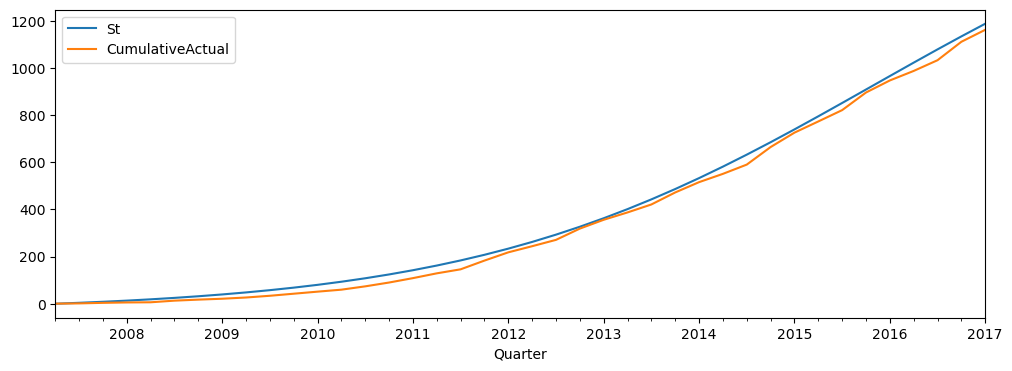

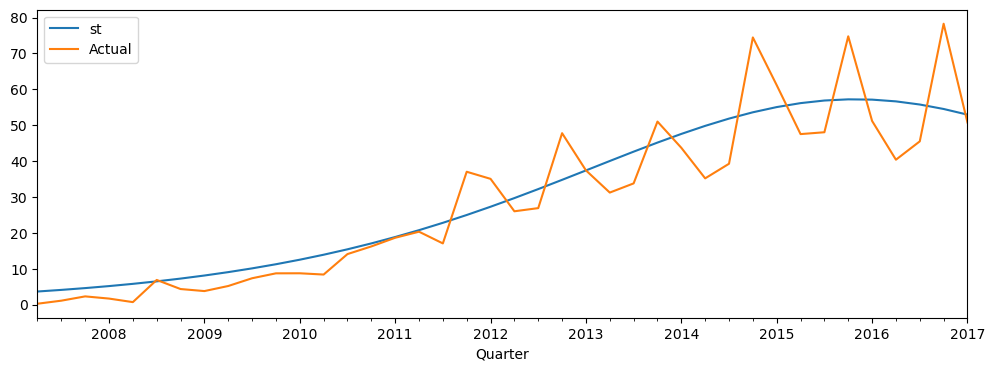

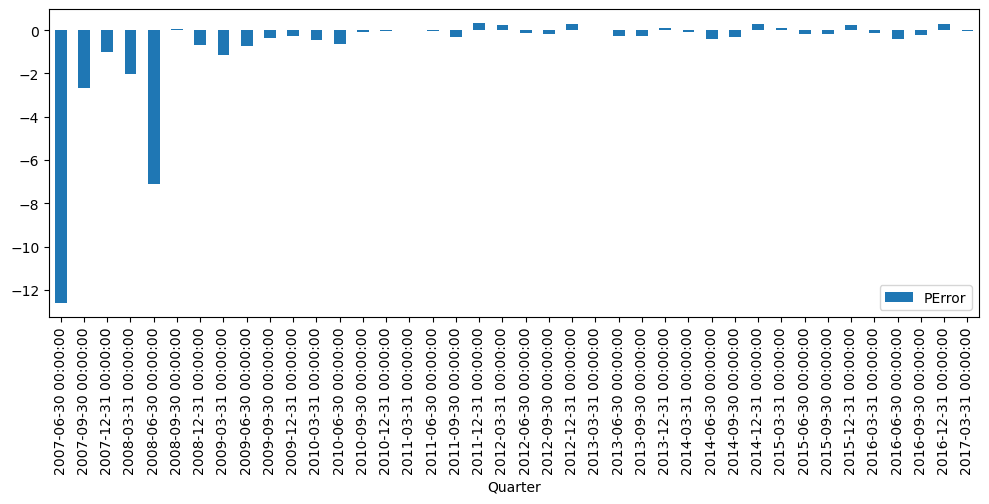

In [20]:
### commencez votre code ici ###
bass_df = bass_df.set_index(quarter_index_date)
bass_df.index.name = "Quarter"
bass_df[['St', 'CumulativeActual']].plot(figsize=(12, 4))
bass_df[['st', 'Actual']].plot(figsize=(12, 4))
bass_df[['PError']].plot(kind='bar', figsize=(12, 4))
### terminez votre code ici ###

<Axes: xlabel='Quarter'>

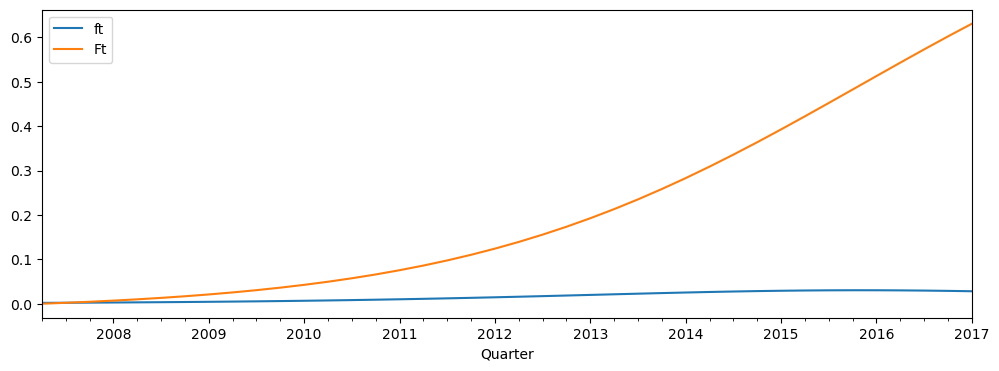

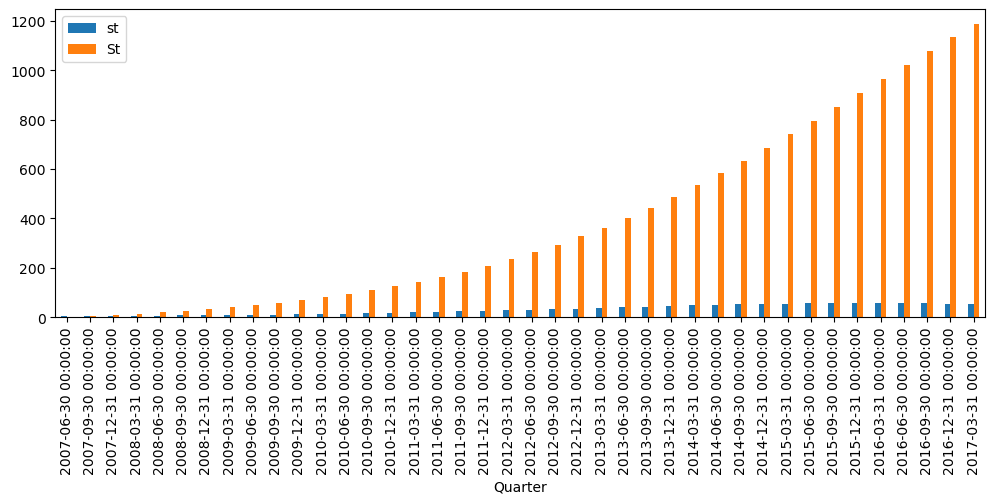

In [21]:
# ## commencez votre code ici ###
bass_df[['ft','Ft']].plot(figsize = (12,4))
bass_df[['st','St']].plot(kind = 'bar', figsize = (12,4))
# ## terminez votre code ici ###

Nous pouvons maintenant comparer les résultats avec les ventes trimestrielles réelles d'iPhone pour les 40 premiers trimestres (à partir du deuxième trimestre 2007, date à laquelle le produit a été lancé pour la première fois).

**Question 3** : Veuillez ajouter les colonnes suivantes et leurs valeurs correspondantes au DataFrame `bass_df`


* Colonne « Actual » : qui contient les ventes réelles du DataFrame « actual_sales »
* Colonne « CumulativeActual » : qui calcule la somme du premier trimestre jusqu'à chaque trimestre de l'indice
* Colonne « PError » : qui calcule le pourcentage d'erreur de chaque trimestre correspondant à partir de la colonne « Actual » et de la colonne « st » (ventes estimées pour chaque trimestre), c'est-à-dire « PError = (Actual-st)/Actual »



In [22]:
# ## commencez votre code ici ###
bass_df['Actual'] = actual_sales['Sales']
bass_df['CumulativeActual'] = [sum(actual_sales.loc[:t,'Sales']) for t in actual_sales['Sales'].index]
bass_df['PError'] = (bass_df['Actual'] - bass_df['st'])/bass_df['Actual']
# ## terminez votre code ici ###
bass_df

,ft,Ft,st,St,Actual,CumulativeActual,PError
Quarter,,,,,,,
2007-06-30,0.001949,0.000000,3.672699,0.000000,NaN,0.270,NaN
2007-09-30,0.002187,0.002066,4.121845,3.893112,NaN,1.389,NaN
2007-12-31,0.002453,0.004384,4.623538,8.261201,NaN,3.704,NaN
2008-03-31,0.002751,0.006983,5.183301,13.159540,NaN,5.407,NaN
2008-06-30,0.003082,0.009896,5.807073,18.649135,NaN,6.124,NaN
2008-09-30,0.003450,0.013159,6.501194,24.797131,NaN,13.016,NaN
2008-12-31,0.003859,0.016809,7.272376,31.677206,NaN,17.379,NaN
2009-03-31,0.004313,0.020892,8.127653,39.369912,NaN,21.172,NaN
2009-06-30,0.004815,0.025452,9.074300,47.962967,NaN,26.380,NaN


Nous pouvons également générer la date du dernier jour de chaque trimestre à l'aide du code ci-dessous. Cette liste sera ensuite utilisée comme nouveaux index.

In [23]:
quarter_index_date = pd.date_range('4/1/2007', periods=40, freq='Q')
quarter_index_date


DatetimeIndex(['2007-06-30', '2007-09-30', '2007-12-31', '2008-03-31',
               '2008-06-30', '2008-09-30', '2008-12-31', '2009-03-31',
               '2009-06-30', '2009-09-30', '2009-12-31', '2010-03-31',
               '2010-06-30', '2010-09-30', '2010-12-31', '2011-03-31',
               '2011-06-30', '2011-09-30', '2011-12-31', '2012-03-31',
               '2012-06-30', '2012-09-30', '2012-12-31', '2013-03-31',
               '2013-06-30', '2013-09-30', '2013-12-31', '2014-03-31',
               '2014-06-30', '2014-09-30', '2014-12-31', '2015-03-31',
               '2015-06-30', '2015-09-30', '2015-12-31', '2016-03-31',
               '2016-06-30', '2016-09-30', '2016-12-31', '2017-03-31'],
              dtype='datetime64[ns]', freq='Q-DEC')

**Question 4** : Veuillez (i) remplacer les index d'origine en utilisant la liste nouvellement créée `quarter_index_date` et (ii) créer ensuite les tracés suivants à partir du DataFrame `bass_df` en utilisant la taille `figsize=(12,4)` :


* Colonnes `['St','CumulativeActual']` utilisant un tracé linéaire
* Colonnes `['st','Actual']` utilisant un tracé linéaire
* Colonne `['PError']` utilisant un graphique à barres

**Astuce** : vous pouvez utiliser la méthode `.set_index(...)` en appelant `bass_df = bass_df.set_index(new_index_list)` pour définir l'index (voir [link](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html))



<Axes: xlabel='Quarter'>

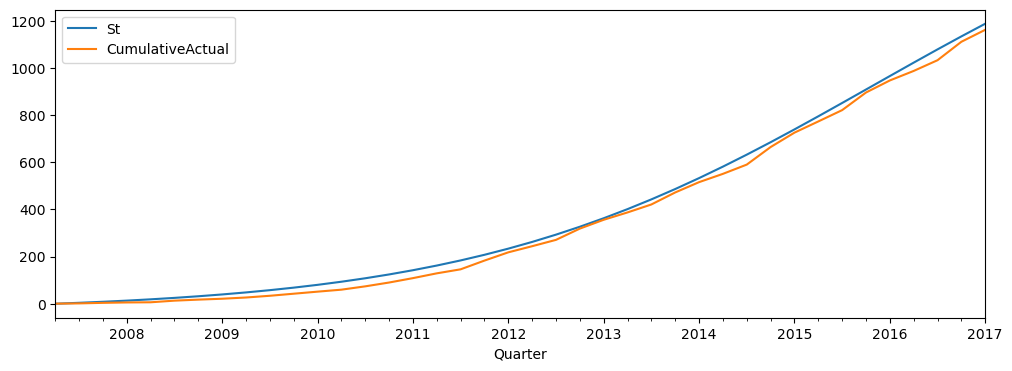

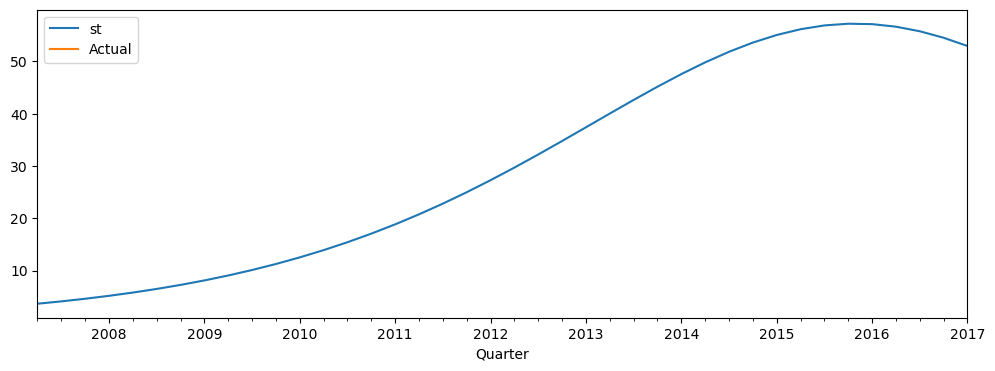

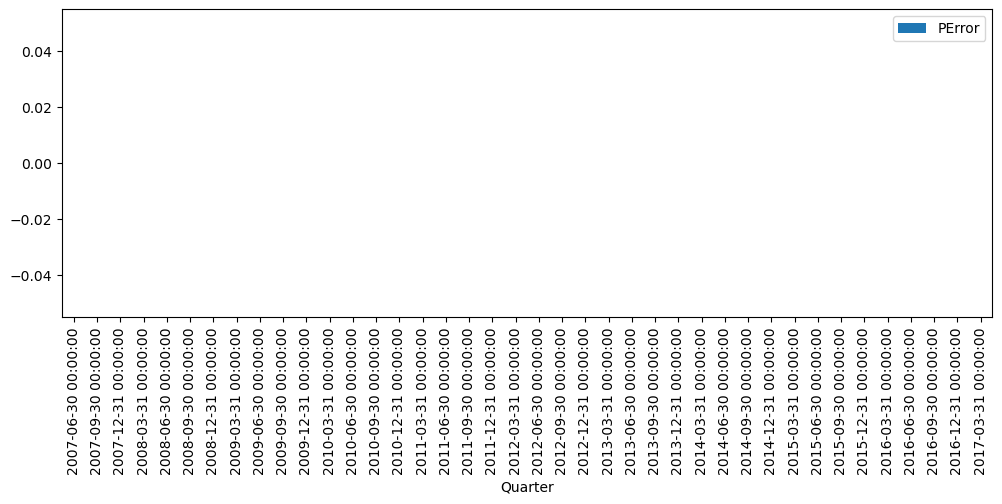

In [24]:
# ## commencez votre code ici ###
bass_df = bass_df.set_index(quarter_index_date)
bass_df.index.names = ['Quarter']
bass_df[['St','CumulativeActual']].plot(figsize=(12,4))
bass_df[['st','Actual']].plot(figsize=(12,4))
bass_df[['PError']].plot(kind='bar',figsize=(12,4))
# ## terminez votre code ici ###